In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/Codes_divers/PlantBiophysics-paper-Quarto/notebooks/evaluation/Fig3`


In [2]:
### A Pluto.jl notebook ###
# v0.19.27

using Markdown
using InteractiveUtils




# Global evaluation of PlantBiophysics.jl: observations vs simulations

This Pluto notebook presents the computation of Fig. 3 from the scientific article. The notebook does not compute anything because it would imply a dependency on R ([plantecophys](https://github.com/RemkoDuursma/plantecophys)) and Python ([LeafGasExchange.jl](https://github.com/cropbox/LeafGasExchange.jl)), which is possible but not performant in Pluto an Github actions. Instead, we display the code and the results only. If you want to reproduce the results, execute the code provided here, or the code from the script provided [here](https://github.com/VEZY/PlantBiophysics-paper/blob/main/tutorials/Fig3_PlantBiophysics_global_evaluation_noPluto.jl).

## Importing the dependencies:

###### Note
Make sure to have R installed on your computer first.




Loading the Julia packages:
```julia
using CSV, Statistics, DataFrames, Downloads, Dates
using AlgebraOfGraphics, CairoMakie, Colors
using PlantBiophysics, PlantSimEngine, PlantMeteo, RCall, LeafGasExchange, Cropbox
using MonteCarloMeasurements
```



In [3]:
begin
    using CSV, Statistics, DataFrames, Downloads, Dates
    using AlgebraOfGraphics, CairoMakie, Colors
    using PlantBiophysics, PlantSimEngine, PlantMeteo
    using PlutoUI
end




Loading the R package (note the use of the `R\"\"\"` macro here that sends the code to R):
```julia
R\"\"\"
library(plantecophys)
\"\"\"
```




## Reading the data




The data comes from Medlyn et al. (2015), see [here](https://figshare.com/articles/dataset/Tumbarumba_Gas_Exchange/1538079?file=3402641) for more details.




In [4]:
df = let
    df_ = read_licor6400(Downloads.download("https://figshare.com/ndownloader/files/3402635"))

    # Computing DateTime from Date and Time:
    transform!(
        df_,
        [:Date, :Time] => ((x, y) -> Date.(x, dateformat"Y/m/d") .+ y) => :Date
    )

    # Initializing the columns:
    df_.VcMaxRef .= df_.JMaxRef .= df_.RdRef .= df_.TPURef .= df_.g0 .= df_.g1 .= df_.Tᵣ .= 0.0
    df_.AsimPB .= df_.EsimPB .= df_.TlsimPB .= df_.GssimPB .= 0.0
    df_.VcMaxRefPE .= df_.JMaxRefPE .= df_.RdRefPE .= df_.TPURefPE .= df_.g0PE .= df_.g1PE .= 0.0
    df_
end



Row,Date,Time,Curve,Qflag,Site,Leaf Age,Chl a+b,Na,Pa,SLA,A,Gₛ,Cᵢ,Trmmol,Dₗ,Area,StmRat,Gbv,T,Tₗ,TBlk,CO2R,Cₐ,H2OR,H2OS,RH_R,Rh,Flow,PPFD,P,VPD,Tᵣ,g1,g0,TPURef,RdRef,JMaxRef,VcMaxRef,GssimPB,TlsimPB,EsimPB,AsimPB,g1PE,g0PE,TPURefPE,RdRefPE,JMaxRefPE,VcMaxRefPE
,DateTime,Time,Int64,Int64,Int64,Int64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2001-11-14T09:38:00,09:38:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,10.5883,0.253715,139.167,2.305,0.566167,6,1,2.84,16.8883,17.7417,16.9367,201.533,188.35,14.0995,16.8195,63.89,0.76215,500.067,1500.17,87.4917,0.459326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2001-11-14T09:40:00,09:40:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,4.19333,0.255732,75.5,2.385,0.5815,6,1,2.84,17.2317,18.0533,17.3183,100.417,95.15,14.2923,17.1083,63.37,0.7586,499.983,1499.67,87.49,0.476431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2001-11-14T09:42:00,09:42:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,0.680833,0.257113,45.6167,2.54167,0.615833,6,1,2.84,17.78,18.5917,17.885,50.15,49.2,14.5342,17.5292,62.2467,0.75075,500.117,1499.17,87.4983,0.50925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2001-11-14T09:44:00,09:44:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,-2.80833,0.256369,17.95,2.65333,0.644333,6,1,2.84,18.3133,19.0883,18.425,2.23333,5.6,14.8568,17.982,61.5383,0.744833,500.3,1499.0,87.495,0.539113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2001-11-14T09:48:00,09:48:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,21.7167,0.244161,269.333,2.54333,0.644833,6,1,2.84,18.6567,19.265,18.845,401.433,374.267,15.2562,18.2513,61.845,0.7399,500.433,1500.0,87.5,0.561485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2001-11-14T09:50:00,09:50:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,33.0167,0.23896,596.5,2.47833,0.639333,6,1,2.84,18.825,19.385,19.0183,802.783,760.9,15.5877,18.5048,62.535,0.742383,500.117,1499.67,87.5083,0.562009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2001-11-14T09:52:00,09:52:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,34.8167,0.23811,779.5,2.45667,0.635667,6,1,2.84,18.9717,19.5333,19.1683,1000.02,955.4,15.8923,18.7838,63.175,0.7467,500.1,1499.83,87.505,0.557676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2001-11-14T09:54:00,09:54:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,36.85,0.235775,966.167,2.43,0.634667,6,1,2.84,19.1633,19.6867,19.345,1202.93,1155.4,16.1855,19.0453,63.575,0.748067,500.267,1500.67,87.5083,0.561338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2001-11-14T09:56:00,09:56:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,32.15,0.219851,981.333,2.12667,0.590667,6,1,2.84,19.2667,19.3167,19.49,1199.08,1157.62,16.4565,18.9562,64.23,0.739867,500.433,999.333,87.51,0.583352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



## Fitting

Photosynthesis and stomatal conductance parameters are fitted using PlantBiophysics.jl here, but it is also possible to use plantecophys instead (see Julia script for more info). Comparison results are close with both.



In [5]:
df_fit = let df_ = df
    for i in unique(df.Curve)
        dfi = filter(x -> x.Curve == i, df_)
        sort!(dfi, :Cᵢ)

        g0, g1 = PlantSimEngine.fit(Medlyn, dfi)
        df_.g0[df.Curve.==i] .= g0
        df_.g1[df.Curve.==i] .= g1

        filter!(x -> x.PPFD > 1400.0, dfi)

        VcMaxRef, JMaxRef, RdRef, TPURef, Tᵣ = PlantSimEngine.fit(Fvcb, dfi)
        df_.VcMaxRef[df_.Curve.==i] .= VcMaxRef
        df_.JMaxRef[df_.Curve.==i] .= JMaxRef
        df_.RdRef[df_.Curve.==i] .= RdRef
        df_.TPURef[df_.Curve.==i] .= TPURef
        df_.Tᵣ[df_.Curve.==i] .= Tᵣ
    end
end




## Simulation

We set the wind velocity to 20 $m.s^{-1}$ considering that the Licor-6400 chamber is well ventilated. The characteristic length is set to the square root of the chamber area in $m^2$. The leaf absorbtance and emissivity are set to the default value from plantecophys.




### PlantBiophysics



In [6]:
begin
    d = sqrt(df.Area[1]) / 100 # Characteristic dimension
    Wind = 20.0 # Wind, in m/s
    Leaf_abs = 0.86 # default from plantecophys
    emissivity = 0.95 # default from plantecophys
end



0.95

In [7]:
df_PB = let df = df
    constants = Constants()
    atm_cols = keys(Atmosphere(T=25.0, Rh=0.5, Wind=10.0))
    for i in unique(df.Curve)
        dfi = filter(x -> x.Curve == i, df)

        cols = fieldnames(Atmosphere)
        dfiMeteo = select(dfi, names(dfi, x -> Symbol(x) in atm_cols))
        dfiMeteo.Wind .= Wind
        # Note that as we only use A-Ci curves, there is no NIR in the Licor6400
        dfiMeteo.Ri_SW_f .= dfi.PPFD .* Leaf_abs ./ (4.57)
        dfiMeteo.check .= false # Remove checks from Atmopshere (P < 87kPa)
        meteo = Weather(dfiMeteo)

        leaf = ModelList(
            energy_balance=Monteith(
                aₛₕ=2,
                aₛᵥ=1,
                ε=emissivity, # Matching the value in plantecophys (https://github.com/RemkoDuursma/plantecophys/blob/c9749828041f10ca47c6691436678e0a5632cfb8/R/LeafEnergyBalance.R#L112)
                maxiter=100,
            ),
            photosynthesis=Fvcb(
                Tᵣ=dfi.Tᵣ[1],
                VcMaxRef=dfi.VcMaxRef[1],
                JMaxRef=dfi.JMaxRef[1],
                RdRef=dfi.RdRef[1],
                TPURef=dfi.TPURef[1],
            ),
            stomatal_conductance=Medlyn(dfi.g0[1], dfi.g1[1]),
            status=(Rₛ=meteo[:Ri_SW_f], sky_fraction=1.0, PPFD=dfi.PPFD, d=d)
        )

        run!(leaf, meteo)
        df.AsimPB[df.Curve.==i, :] = DataFrame(leaf).A
        df.EsimPB[df.Curve.==i, :] = DataFrame(leaf).λE ./ (meteo[:λ] * constants.Mₕ₂ₒ) * 1000
        df.TlsimPB[df.Curve.==i, :] = DataFrame(leaf).Tₗ
        df.GssimPB[df.Curve.==i, :] = DataFrame(leaf).Gₛ
    end
    df
end



┌ Warning: P (86.89857143) should be in kPa (i.e. 101.325 kPa at sea level), please consider converting it
└ @ PlantMeteo /Users/arsouze/.julia/packages/PlantMeteo/HpPR0/src/structs/atmosphere.jl:90


Row,Date,Time,Curve,Qflag,Site,Leaf Age,Chl a+b,Na,Pa,SLA,A,Gₛ,Cᵢ,Trmmol,Dₗ,Area,StmRat,Gbv,T,Tₗ,TBlk,CO2R,Cₐ,H2OR,H2OS,RH_R,Rh,Flow,PPFD,P,VPD,Tᵣ,g1,g0,TPURef,RdRef,JMaxRef,VcMaxRef,GssimPB,TlsimPB,EsimPB,AsimPB,g1PE,g0PE,TPURefPE,RdRefPE,JMaxRefPE,VcMaxRefPE
,DateTime,Time,Int64,Int64,Int64,Int64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2001-11-14T09:38:00,09:38:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,10.5883,0.253715,139.167,2.305,0.566167,6,1,2.84,16.8883,17.7417,16.9367,201.533,188.35,14.0995,16.8195,63.89,0.76215,500.067,1500.17,87.4917,0.459326,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.253136,17.8155,2.33848,9.54724,0.0,0.0,0.0,0.0,0.0,0.0
2,2001-11-14T09:40:00,09:40:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,4.19333,0.255732,75.5,2.385,0.5815,6,1,2.84,17.2317,18.0533,17.3183,100.417,95.15,14.2923,17.1083,63.37,0.7586,499.983,1499.67,87.49,0.476431,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.235755,18.1743,2.27435,3.64789,0.0,0.0,0.0,0.0,0.0,0.0
3,2001-11-14T09:42:00,09:42:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,0.680833,0.257113,45.6167,2.54167,0.615833,6,1,2.84,17.78,18.5917,17.885,50.15,49.2,14.5342,17.5292,62.2467,0.75075,500.117,1499.17,87.4983,0.50925,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.195849,18.7731,2.05908,0.444311,0.0,0.0,0.0,0.0,0.0,0.0
4,2001-11-14T09:44:00,09:44:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,-2.80833,0.256369,17.95,2.65333,0.644333,6,1,2.84,18.3133,19.0883,18.425,2.23333,5.6,14.8568,17.982,61.5383,0.744833,500.3,1499.0,87.495,0.539113,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.18388,19.31,2.04719,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2001-11-14T09:48:00,09:48:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,21.7167,0.244161,269.333,2.54333,0.644833,6,1,2.84,18.6567,19.265,18.845,401.433,374.267,15.2562,18.2513,61.845,0.7399,500.433,1500.0,87.5,0.561485,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.25292,19.4951,2.7497,19.2821,0.0,0.0,0.0,0.0,0.0,0.0
6,2001-11-14T09:50:00,09:50:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,33.0167,0.23896,596.5,2.47833,0.639333,6,1,2.84,18.825,19.385,19.0183,802.783,760.9,15.5877,18.5048,62.535,0.742383,500.117,1499.67,87.5083,0.562009,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.23756,19.693,2.62041,30.654,0.0,0.0,0.0,0.0,0.0,0.0
7,2001-11-14T09:52:00,09:52:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,34.8167,0.23811,779.5,2.45667,0.635667,6,1,2.84,18.9717,19.5333,19.1683,1000.02,955.4,15.8923,18.7838,63.175,0.7467,500.1,1499.83,87.505,0.557676,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.228716,19.8608,2.53041,32.235,0.0,0.0,0.0,0.0,0.0,0.0
8,2001-11-14T09:54:00,09:54:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,36.85,0.235775,966.167,2.43,0.634667,6,1,2.84,19.1633,19.6867,19.345,1202.93,1155.4,16.1855,19.0453,63.575,0.748067,500.267,1500.67,87.5083,0.561338,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.22219,20.0635,2.48815,33.4133,0.0,0.0,0.0,0.0,0.0,0.0
9,2001-11-14T09:56:00,09:56:00,1,1,2,0,434.0988776,2.42908,0.194452,5.169,32.15,0.219851,981.333,2.12667,0.590667,6,1,2.84,19.2667,19.3167,19.49,1199.08,1157.62,16.4565,18.9562,64.23,0.739867,500.433,999.333,87.51,0.583352,18.9181,0.256523,0.18388,11.3072,0.0,178.17,77.6146,0.217672,19.7207,2.29927,29.3508,0.0,0.0,0.0,0.0,0.0,0.0


 
### plantecophys

Below is presented the code for running the exact same simulation with the two other packages.

!!! note
	The code shown here for plantecophys and LeafGasExchange.jl is not executed, just displayed. If you want to reproduce the computation, please use the script instead.




```julia
begin
	if !simulated
				
		R\"\"\"
		A_sim = c()
		E_sim = c()
		Tl_sim = c()
		Gs_sim = c()
		failed =c()
		\"\"\"

		df.AsimPE .= df.EsimPE .= df.TlsimPE .= df.GssimPE .= df.PEfailed .= 0.
		for i in unique(df.Curve)
		    dfi = filter(x->x.Curve == i,df)
		    dfi = dfi[:,3:end]
		    @rput dfi
		    Ca = dfi.Cₐ
		    @rput Ca
		    R\"\"\"
		    VcMaxRef = dfi$VcMaxRefPE[1]
		    JMaxRef = dfi$JMaxRefPE[1]
		    TPURef = dfi$TPURefPE[1]
		    RdRef = dfi$RdRefPE[1]
		    g0 = dfi$g0PE[1]
		    g1 = dfi$g1PE[1]
		    res = PhotosynEB(Tair = dfi$T,Wind = Wind,VPD=dfi$VPD,
		             Wleaf = d,Ca = Ca,  StomatalRatio = 1,
		             LeafAbs = 1.,gsmodel = "BBOpti",g0 = g0, g1 = g1,
		             EaV = 58550.0,EdVC = 2e+05, delsC = 629.26,
		             EaJ = 29680.0,EdVJ = 2e+05,delsJ = 631.88,
		             alpha = 0.24,theta = 0.7, Jmax = JMaxRef, 
		             Vcmax = VcMaxRef, TPU = TPURef,Rd = RdRef,
		             RH = dfi$Rh*100,PPFD=dfi$PPFD,
		             Patm = dfi$P,gk=0.,
		             Tcorrect = FALSE)
		    A_sim = append(A_sim,res$ALEAF)
		    Gs_sim = append(Gs_sim,res$GS)
		    failed = append(failed,res$failed)
		    Tl_sim = append(Tl_sim,res$Tleaf)
		    E_sim = append(E_sim,res$ELEAF)
		    \"\"\"
		end
		@rget A_sim
		
		@rget failed
		@rget Gs_sim
		@rget E_sim
		@rget Tl_sim
		
		df.AsimPE .= A_sim
		df.EsimPE .= E_sim
		df.TlsimPE .= Tl_sim
		df.GssimPE .= Gs_sim
		df.PEfailed .= failed
	end
end
```




### LeafGasExchange.jl




```julia
begin
	df.AsimLG .= df.EsimLG .= df.TlsimLG .= df.GssimLG .= 0.0
	for i in unique(df.Curve)
	    dfi = filter(x -> x.Curve == i, df)
	    configs = []
	    for i in 1:length(dfi.T)
	        config = :Weather => (
	            PFD=dfi.PPFD[i],
	            CO2=dfi.Cₐ[i],
	            RH=dfi.Rh[i] * 100,
	            T_air=dfi.T[i],
	            wind=Wind,
	            P_air=dfi.P[i],
	            g0=dfi.g0[i],
	            g1=1.57 * dfi.g1[i],
	            Vc25=dfi.VcMaxRef[i],
	            Jm25=dfi.JMaxRef[i],
	            Rd25=dfi.RdRef[i],
	            Tp25=dfi.TPURef[i],
	            Ear=46.39,
	            Haj=29.68,
	            w=d,
	            d=d,
	            EaVc=58.55,
	            ϵ=emissivity,
	            Dh=21.5,
	            α_s=1 - Leaf_abs
	        )
	        push!(configs, config)
	    end
	    res = simulate(ModelC3MD; configs=configs, nounit=true)
	    df.AsimLG[df.Curve.==i, :] = res.A_net
	    df.EsimLG[df.Curve.==i, :] = res.E
	    df.TlsimLG[df.Curve.==i, :] = res.T
	    df.GssimLG[df.Curve.==i, :] = res.gsc
	end
end
```




## Stacking the results

Here we stack the results in a long-format DataFrame for computing the statistics:



In [8]:
begin
    meas =
        stack(
            select(
                df,
                [:Date => :Date, :Cₐ => :Cₐ, :A => :A, :Trmmol => :E, :Tₗ => :Tl, :Gₛ => :Gs]
            ),
            [:A, :E, :Tl, :Gs],
            [:Date, :Cₐ],
            value_name=:measured
        )

    sim_PB =
        stack(
            select(
                df_PB,
                [:Date => :Date, :AsimPB => :A, :EsimPB => :E, :TlsimPB => :Tl, :GssimPB => :Gs]
            ),
            [:A, :E, :Tl, :Gs],
            :Date,
            value_name=:simulated
        )
    sim_PB.origin .= "PlantBiophysics.jl"
    sim_PB
end



Row,Date,variable,simulated,origin
,DateTime,String,Float64,String
1,2001-11-14T09:38:00,A,9.54724,PlantBiophysics.jl
2,2001-11-14T09:40:00,A,3.64789,PlantBiophysics.jl
3,2001-11-14T09:42:00,A,0.444311,PlantBiophysics.jl
4,2001-11-14T09:44:00,A,0.0,PlantBiophysics.jl
5,2001-11-14T09:48:00,A,19.2821,PlantBiophysics.jl
6,2001-11-14T09:50:00,A,30.654,PlantBiophysics.jl
7,2001-11-14T09:52:00,A,32.235,PlantBiophysics.jl
8,2001-11-14T09:54:00,A,33.4133,PlantBiophysics.jl
9,2001-11-14T09:56:00,A,29.3508,PlantBiophysics.jl



Same for the other packages, though the data is not available in the notebook:




```julia
begin 
	sim_LG =
		    stack(
		        select(
		            df,
		            [:Date => :Date, :AsimLG => :A, :EsimLG => :E, :TlsimLG => :Tl, :GssimLG => :Gs]
		        ),
		        [:A, :E, :Tl, :Gs],
		        :Date,
		        value_name=:simulated
		    )
		sim_LG.origin .= "LeafGasExchange.jl"
		
		sim_PE = stack(
		    select(
		        df,
		        [:Date => :Date, :AsimPE => :A, :EsimPE => :E, :TlsimPE => :Tl, :GssimPE => :Gs]
		    ),
		    [:A, :E, :Tl, :Gs],
		    :Date,
		    value_name=:simulated
		)
		sim_PE.origin .= "plantecophys"
end
```




And finally we can stack the results together:




```julia
begin 
	df_all = vcat(sim_PB, sim_LG, sim_PE)
	df_res = leftjoin(df_all, meas, on=[:Date, :variable])
end
```




Note that the real code executed here is the following, because neither `sim_LG` or `sim_PE` are available:



In [9]:
begin
    df_all = sim_PB
    df_res = leftjoin(df_all, meas, on=[:Date, :variable])
    # Filtering out the results for very low Cₐ:
    filter!(x -> x.Cₐ > 150, df_res)
    filter!(x -> x.Cₐ > 150, df)
    df_res
end



Row,Date,variable,simulated,origin,Cₐ,measured
,DateTime,String,Float64,String,Float64?,Float64?
1,2001-11-14T09:38:00,A,9.54724,PlantBiophysics.jl,188.35,10.5883
2,2001-11-14T09:48:00,A,19.2821,PlantBiophysics.jl,374.267,21.7167
3,2001-11-14T09:50:00,A,30.654,PlantBiophysics.jl,760.9,33.0167
4,2001-11-14T09:52:00,A,32.235,PlantBiophysics.jl,955.4,34.8167
5,2001-11-14T09:54:00,A,33.4133,PlantBiophysics.jl,1155.4,36.85
6,2001-11-14T09:56:00,A,29.3508,PlantBiophysics.jl,1157.62,32.15
7,2001-11-14T09:58:00,A,20.3233,PlantBiophysics.jl,1168.7,23.9833
8,2001-11-14T10:00:00,A,9.77645,PlantBiophysics.jl,1184.58,10.7583
9,2001-11-14T10:02:00,A,5.16737,PlantBiophysics.jl,1195.37,6.26167



## Statistics

Computing the statistics for each model:



In [10]:
"""
	rgb(r, g, b, a)

Like `Colors.RGBA` but accepts colors in the 0-255 range.
"""
function rgb(r, g, b, a)
    return RGBA(r / 255, g / 255, b / 255, a)
end


"""
    RMSE(obs,sim)

Returns the Root Mean Squared Error between observations `obs` and simulations `sim`.
The closer to 0 the better.
"""
function RMSE(obs, sim, digits=2)
    return round(sqrt(sum((obs .- sim) .^ 2) / length(obs)), digits=digits)
end


"""
    nRMSE(obs,sim)

Returns the normalized Root Mean Squared Error between observations `obs` and simulations `sim`.
The closer to 0 the better.
"""
function nRMSE(obs, sim; digits=2)
    return round(sqrt(sum((obs .- sim) .^ 2) / length(obs)) / (findmax(obs)[1] - findmin(obs)[1]), digits=digits)
end


"""
    EF(obs,sim)

Returns the Efficiency Factor between observations `obs` and simulations `sim` using NSE (Nash-Sutcliffe efficiency) model.
More information can be found at https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient.
The closer to 1 the better.
"""
function EF(obs, sim, digits=2)
    SSres = sum((obs - sim) .^ 2)
    SStot = sum((obs .- mean(obs)) .^ 2)
    return round(1 - SSres / SStot, digits=digits)
end


"""
	    Bias(obs,sim)

	Returns the bias between observations `obs` and simulations `sim`.
	The closer to 0 the better.
	"""
function Bias(obs, sim, digits=4)
    return round(mean(sim .- obs), digits=digits)
end


"""
	nBias(obs,sim; digits = 2)

Returns the normalised bias (%) between observations `obs` and simulations `sim`.
The closer to 0 the better.
"""
function nBias(obs, sim; digits=2)
    return round(mean((sim .- obs)) / (findmax(obs)[1] - findmin(obs)[1]), digits=digits)
end



nBias

In [11]:
stats =
    combine(
        groupby(df_res, [:variable, :origin], sort=true),
        [:measured, :simulated] => ((x, y) -> RMSE(x, y)) => :RMSE,
        [:measured, :simulated] => ((x, y) -> nRMSE(x, y)) => :nRMSE,
        [:measured, :simulated] => ((x, y) -> Bias(x, y)) => :Bias,
        [:measured, :simulated] => ((x, y) -> nBias(x, y)) => :nBias,
        [:measured, :simulated] => ((x, y) -> EF(x, y)) => :EF
    )



Row,variable,origin,RMSE,nRMSE,Bias,nBias,EF
,String,String,Float64,Float64,Float64,Float64,Float64
1,A,PlantBiophysics.jl,1.49,0.03,-0.0309,-0.0,0.98
2,E,PlantBiophysics.jl,0.48,0.05,0.2722,0.03,0.9
3,Gs,PlantBiophysics.jl,0.02,0.07,0.0074,0.02,0.88
4,Tl,PlantBiophysics.jl,0.52,0.02,0.3434,0.02,0.99



## Plotting




### Observations vs simulations (Fig. 3)



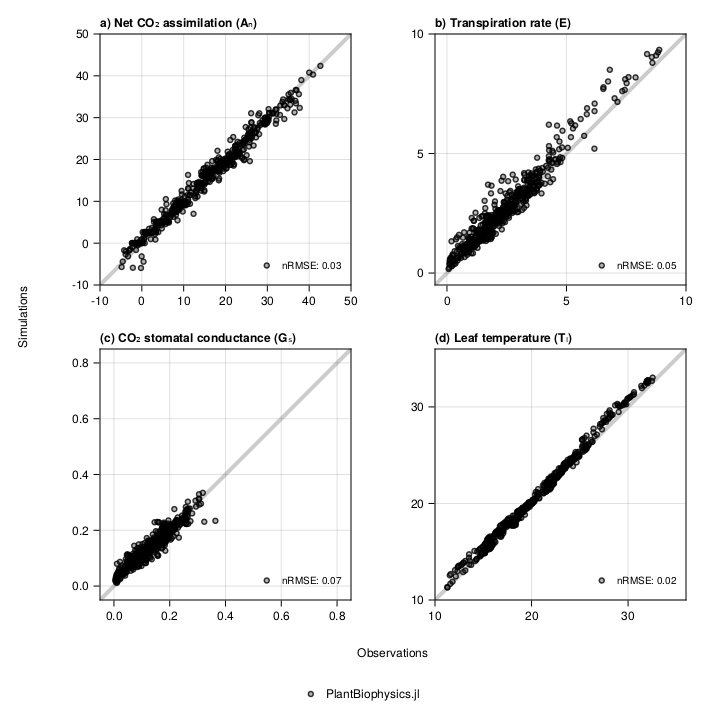

In [12]:
begin
    transparency_col = 0.8
    transparency_fill = 0.3
    color_pb = rgb(0, 0, 0, transparency_col)
    color_lg = rgb(223, 120, 97, transparency_col)
    color_pe = rgb(118, 84, 154, transparency_col)
    fill_pb = rgb(0, 0, 0, transparency_fill)
    fill_lg = rgb(223, 120, 97, transparency_fill)
    fill_pe = rgb(118, 84, 154, transparency_fill)
    stw = 1.5 # strokewidth
    ms = 7 # markersize
    noto_sans = assetpath("fonts", "NotoSans-Regular.ttf")
    legend_lab_size = 10
    size_inches = (10, 10)
    size_pt = 72 .* size_inches
    fig = Figure(
        font=noto_sans,
        resolution=size_pt,
        fontsize=12,
        xminorgridstyle=true,
	backgroundcolor = :white
    )

    sideinfo1 = Label(fig[1:2, 1], "Simulations", rotation=pi / 2, fontsize=12)
    sideinfo2 = Label(fig[3, 2:3], "Observations", fontsize=12)

    # Assimilation
    axa = Axis(fig[1, 2], title="a) Net CO₂ assimilation (Aₙ)", aspect=1, titlealign=:left)
    xlims!(-10.0, 50.0)
    ylims!(-10.0, 50.0)

    ablines!(axa, 0, 1, color=(:grey, 0.4), linewidth=4)

    # LG = scatter!(
    #     axa, df.A, df.AsimLG,
    #     color=fill_lg,
    #     markersize=ms,
    #     strokecolor=color_lg,
    #     strokewidth=stw
    # )
    # PE = scatter!(axa, df.A, df.AsimPE,
    #     color=fill_pe,
    #     markersize=ms,
    #     strokecolor=color_pe,
    #     strokewidth=stw
    # )
    PB = scatter!(axa, df.A, df.AsimPB,
        color=fill_pb,
        markersize=ms,
        strokecolor=color_pb,
        strokewidth=stw
    )
    axislegend(
        axa,
        [PB],
        [
            "nRMSE: " * string(filter(x -> x.variable == "A" && x.origin == "PlantBiophysics.jl", stats).nRMSE[1]),
        ],
        "",
        position=:rb,
        orientation=:vertical,
        labelsize=legend_lab_size,
        padding=0.0,
        framevisible=false
    )

    # Transpiration
    axb = Axis(fig[1, 3], title="b) Transpiration rate (E)", aspect=1, titlealign=:left)
    xlims!(-0.5, 10.0)
    ylims!(-0.5, 10.0)

    ablines!(axb, 0, 1, color=(:grey, 0.4), linewidth=4)

    # LG = scatter!(axb, df.Trmmol, df.EsimLG,
    #     color=fill_lg,
    #     markersize=ms,
    #     strokecolor=color_lg,
    #     strokewidth=stw
    # )
    # PE = scatter!(axb, df.Trmmol, df.EsimPE,
    #     color=fill_pe,
    #     markersize=ms,
    #     strokecolor=color_pe,
    #     strokewidth=stw
    # )
    PB = scatter!(axb, df.Trmmol, df.EsimPB,
        color=fill_pb,
        markersize=ms,
        strokecolor=color_pb,
        strokewidth=stw
    )
    axislegend(
        axb,
        [PB],
        [
            "nRMSE: " * string(filter(x -> x.variable == "E" && x.origin == "PlantBiophysics.jl", stats).nRMSE[1]),
            # "nRMSE: " * string(filter(x -> x.variable == "E" && x.origin == "plantecophys", stats).nRMSE[1]),
            # "nRMSE: " * string(filter(x -> x.variable == "E" && x.origin == "LeafGasExchange.jl", stats).nRMSE[1]),
        ],
        "", position=:rb,
        orientation=:vertical,
        labelsize=legend_lab_size,
        padding=0.0,
        framevisible=false
    )

    # Stomatal conductance
    axc = Axis(
        fig[2, 2],
        title="(c) CO₂ stomatal conductance (Gₛ)",
        aspect=1,
        titlealign=:left
    )
    xlims!(-0.05, 0.85)
    ylims!(-0.05, 0.85)

    ablines!(axc, 0, 1, color=(:grey, 0.4), linewidth=4)

    # LG = scatter!(axc, df.Gₛ, df.GssimLG,
    #     color=fill_lg,
    #     markersize=ms,
    #     strokecolor=color_lg,
    #     strokewidth=stw,
    #     label="LeafGasExchange.jl"
    # )
    # PE = scatter!(axc, df.Gₛ, df.GssimPE,
    #     color=fill_pe,
    #     markersize=ms,
    #     strokecolor=color_pe,
    #     label="plantecophys",
    #     strokewidth=stw,
    # )
    PB = scatter!(axc, df.Gₛ, df.GssimPB,
        color=fill_pb,
        markersize=ms,
        strokecolor=color_pb,
        strokewidth=stw,
        label="PlantBiophysics.jl"
    )

    axislegend(
        axc,
        [PB],
        [
            "nRMSE: " * string(filter(x -> x.variable == "Gs" && x.origin == "PlantBiophysics.jl", stats).nRMSE[1]),
            # "nRMSE: " * string(filter(x -> x.variable == "Gs" && x.origin == "plantecophys", stats).nRMSE[1]),
            # "nRMSE: " * string(filter(x -> x.variable == "Gs" && x.origin == "LeafGasExchange.jl", stats).nRMSE[1]),
        ],
        "",
        position=:rb,
        orientation=:vertical,
        labelsize=legend_lab_size,
        padding=0.0,
        framevisible=false
    )


    # Leaf temperature
    axd = Axis(fig[2, 3], title="(d) Leaf temperature (Tₗ)", aspect=1, titlealign=:left)
    ablines!(axd, 0, 1, color=(:grey, 0.4), linewidth=4)

    # LG = scatter!(axd, df.Tₗ, df.TlsimLG,
    #     color=fill_lg,
    #     markersize=ms,
    #     strokecolor=color_lg,
    #     strokewidth=stw
    # )
    # PE = scatter!(axd, df.Tₗ, df.TlsimPE,
    #     color=fill_pe,
    #     markersize=ms,
    #     strokecolor=color_pe,
    #     strokewidth=stw
    # )
    PB = scatter!(axd, df.Tₗ, df.TlsimPB,
        color=fill_pb,
        markersize=ms,
        strokecolor=color_pb,
        strokewidth=stw
    )

    xlims!(10.0, 36.0)
    ylims!(10.0, 36.0)

    axislegend(
        axd, [PB],
        [
            "nRMSE: " * string(filter(x -> x.variable == "Tl" && x.origin == "PlantBiophysics.jl", stats).nRMSE[1]),
            # "nRMSE: " * string(filter(x -> x.variable == "Tl" && x.origin == "plantecophys", stats).nRMSE[1]),
            # "nRMSE: " * string(filter(x -> x.variable == "Tl" && x.origin == "LeafGasExchange.jl", stats).nRMSE[1]),
        ],
        "", position=:rb,
        orientation=:vertical,
        labelsize=legend_lab_size,
        padding=0.0,
        framevisible=false
    )

    Legend(
        fig[4, 1:end],
        axc,
        orientation=:horizontal,
        framevisible=false,
        padding=0.0
    )
    fig
end




*Figure 1. Measured (x) and simulated (y) net carbon assimilation (a), net transpiration rate (b), stomatal conductance for CO2 (c) and leaf temperature (d). Data comes from Eucalyptus delegatensis (Medlyn et al., 2015). All simulations were performed using a photosynthesis-stomatal conductance-energy balance coupled model with PlantBiophysics.jl. Grey line represents x=y. All simulations were done with Ca > 150 ppm*




The full validation that includes all three packages would give the following plot:

![Full validation plot](https://raw.githubusercontent.com/VEZY/PlantBiophysics-paper/main/notebooks/evaluation/figure_global_simulation.png)




## References



In [13]:
TableOfContents(title="📚 Table of Contents", indent=true, depth=4, aside=true)



TableOfContents("📚 Table of Contents", true, 4, true, false)